Задача: дано порядка 70000 данных на train - время и различные срезы данных по продажам для каждого товара item_id. Нужно научиться предсказывать продажи на 3 недели вперед.

Подключим все нужное и считаем данные.

In [1]:
import pandas as pd
from sklearn import model_selection, metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import xgboost
import os
%pylab inline

train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")
sample_submission_a = pd.read_csv("boost_submission_a.csv")
sample_submission_b = pd.read_csv("boost_submission_b.csv")

/home/boyalex/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


## 1
Сначала напишем функцию ошибки SMAPE и создадим scorer, чтобы его можно было передавать в cross_val_score и GridSearch.

In [2]:
def score_func(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return (np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))).mean() * 200.
    return s

scorer = metrics.make_scorer(score_func=score_func, greater_is_better=False)

Будем обучаться на всех данных.

In [3]:
frac = 1.

train = train.sample(frac=frac, random_state=42)

X = train.drop(['Num','y'], axis=1)
y = train['y']

pd.set_option('max_columns', 64)

## 2
Теперь посмотрим на данные. Особенные подозрения сразу вызывают фичи f1-f60, возможно некоторые из них зависимы и от них стоит избавиться.

In [4]:
X.head(20)

,year,week,shift,item_id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
44283,2014,13,1,20452327,129441.0,104610.0,121114.0,133780.0,122580.0,126830.0,102220.0,117450.0,113460.0,150970.0,72710.0,110530.0,128170.0,139070.0,91350.0,116210.0,129225.0,162615.0,99390.0,55160.0,95880.0,88520.0,107270.0,79610.0,99210.0,114561.0,93790.0,98070.0,83980.0,105240.0,129441.0,104610.0,121114.0,133780.0,122580.0,126830.0,102220.0,117450.0,113460.0,150970.0,72710.0,110530.0,128170.0,139070.0,91350.0,116210.0,129225.0,162615.0,99390.0,55160.0,95880.0,88520.0,107270.0,79610.0,99210.0,114561.0,93790.0,98070.0,83980.0,105240.0
50871,2014,23,1,20441989,4162.0,6760.0,7210.0,11330.0,6950.0,6798.0,9470.0,13332.0,6860.0,3270.0,8200.0,7580.0,9066.0,6906.0,8184.0,9144.0,9404.0,7075.0,7319.0,8162.0,9932.0,8908.0,10464.0,7431.0,10334.0,11548.0,8698.0,8696.0,8160.0,7570.0,4162.0,6760.0,7210.0,11330.0,6950.0,6798.0,9470.0,13332.0,6860.0,3270.0,8200.0,7580.0,9066.0,6906.0,8184.0,9144.0,9404.0,7075.0,7319.0,8162.0,9932.0,8908.0,10464.0,7431.0,10334.0,11548.0,8698.0,8696.0,8160.0,7570.0
13810,2013,21,3,20438706,24931.0,30338.0,30690.0,37930.0,21420.0,28240.0,28685.0,39205.0,22670.0,29780.0,31855.0,54106.0,18690.0,16835.0,27255.0,25706.0,24705.0,24015.0,27735.0,26515.0,34475.0,22390.0,27124.0,29660.0,30105.0,28054.0,31545.0,28185.0,34890.0,28790.0,24931.0,30338.0,30690.0,37930.0,21420.0,28240.0,28685.0,39205.0,22670.0,29780.0,31855.0,54106.0,18690.0,16835.0,27255.0,25706.0,24705.0,24015.0,27735.0,26515.0,34475.0,22390.0,27124.0,29660.0,30105.0,28054.0,31545.0,28185.0,34890.0,28790.0
10062,2013,15,2,20438591,11505.0,13550.0,15360.0,14750.0,12961.0,9880.0,11950.0,11269.0,15840.0,7720.0,11150.0,11370.0,15980.0,7990.0,12120.0,12370.0,21010.0,5730.0,4880.0,13690.0,10920.0,14030.0,8060.0,8430.0,9980.0,13930.0,6340.0,7810.0,8960.0,10260.0,11505.0,13550.0,15360.0,14750.0,12961.0,9880.0,11950.0,11269.0,15840.0,7720.0,11150.0,11370.0,15980.0,7990.0,12120.0,12370.0,21010.0,5730.0,4880.0,13690.0,10920.0,14030.0,8060.0,8430.0,9980.0,13930.0,6340.0,7810.0,8960.0,10260.0
37186,2014,3,2,20449525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,2090.0,2470.0,1145.0,2955.0,3915.0,740.0,2260.0,1403.0,1417.0,980.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,2090.0,2470.0,1145.0,2955.0,3915.0,740.0,2260.0,1403.0,1417.0,980.0
11779,2013,17,1,20442117,58566.0,30476.0,27444.0,35176.0,37784.0,61653.0,24411.0,33302.0,40347.0,66246.0,21820.0,32870.0,32826.0,76585.0,14414.0,17140.0,30783.0,25557.0,50060.0,18640.0,23909.0,22744.0,47030.0,17352.0,18392.0,20060.0,35480.0,18256.0,16277.0,14780.0,58566.0,30476.0,27444.0,35176.0,37784.0,61653.0,24411.0,33302.0,40347.0,66246.0,21820.0,32870.0,32826.0,76585.0,14414.0,17140.0,30783.0,25557.0,50060.0,18640.0,23909.0,22744.0,47030.0,17352.0,18392.0,20060.0,35480.0,18256.0,16277.0,14780.0
19487,2013,28,1,20427463,8280.0,8900.0,14780.0,5194.0,4070.0,8050.0,9540.0,10020.0,5520.0,7870.0,7710.0,12471.0,5340.0,7612.0,7716.0,8643.0,7860.0,7950.0,8896.0,13340.0,8190.0,7600.0,11130.0,11349.0,16290.0,7410.0,5360.0,10620.0,12701.0,8141.0,8280.0,8900.0,14780.0,5194.0,4070.0,8050.0,9540.0,10020.0,5520.0,7870.0,7710.0,12471.0,5340.0,7612.0,7716.0,8643.0,7860.0,7950.0,8896.0,13340.0,8190.0,7600.0,11130.0,11349.0,16290.0,7410.0,5360.0,10620.0,12701.0,8141.0
13814,2013,21,3,20438803,54836.0,73042.0,77779.0,134052.0,61791.0,56961.0,80549.0,96744.0,81685.0,81735.0,89350.0,214545.0,62586.0,44214.0,60180.0,61831.0,113651.0,57998.0,57975.0,65771.0,112410.0,60409.0,78766.0,81732.0,140618.0,142027.0,67727.0,74731.0,102966.0,117584.0,54836.0,73042.0,77779.0,134052.0,61791.0,56961.0,80549.0,96744.0,81685.0,81735.0,89350.0,214545.0,62586.0,44214.0,60180.0,61831.0,113651.0,57998.0,57975.0,65771.0,112410.0,60409.0,78766.0,81732.0

Можно заметить, что фичи f31-f60 полная копия f1-f30. Проверим этом и избавимся от них. Сделаем 3 модели xgboost. Первая - со всеми данными на всех фичах. Вторая - без повторяющихся f31-f60. Последняя - еще меньше фичей.

Теперь будем последовательно подбирать параметры xgboost. Перебирать все параметры сразу - слишком долго считается. Поэтому пойдем от основных параметров, как число деревьев или глубина, к менее значимым (возможно). Сначала будем искать параметр с большим шагом, потом уменьшать шаг.

Так как данные зависят от времени, то будем использовать специальное разбиение учитывающее временную зависимость (нельзя брать куски данных из "будущего").

Считаются модели долго, поэтому перезапускать не стоит. Перед созданием модели подогнанные параметры сохранены. Как показала практика - первая самая простая модель в комбинации с работой над данными дала наилучшие результаты, поэтому код подбора ее параметров приведен, остальных - нет.

## Первая модель - на всех данных на всех фичах.

In [5]:
params_height = {
    'learning_rate': [0.1],
    'n_estimators': [70, 100, 120, 150, 175, 200, 225]
}

zero = model_selection.GridSearchCV(xgboost.XGBRegressor(silent=False), params_height, 
                                 scoring=scorer, cv=model_selection.TimeSeriesSplit(), 
                                 fit_params={'eval_metric' : 'mae'})

In [6]:
%%time
zero.fit(X, y)

CPU times: user 12min 18s, sys: 4.6 s, total: 12min 23s
Wall time: 3min 16s


GridSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1),
       fit_params={'eval_metric': 'mae'}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [70, 100, 120, 150, 175, 200, 225], 'learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(score_func, greater_is_better=False), verbose=0)

In [7]:
# to produce 'beep' sound when finished
length = 0.4
frequency = 1000
os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (length, frequency))

0

In [8]:
zero.best_params_

{'learning_rate': 0.1, 'n_estimators': 120}

In [9]:
params_height = {
    'learning_rate': [0.1],
    'n_estimators': [115, 120, 125, 130, 135]
}

zero = model_selection.GridSearchCV(xgboost.XGBRegressor(silent=False), params_height, 
                                 scoring=scorer, cv=model_selection.TimeSeriesSplit(), 
                                 fit_params={'eval_metric' : 'mae'})

In [10]:
%%time
zero.fit(X, y)

CPU times: user 8min 12s, sys: 3.6 s, total: 8min 16s
Wall time: 2min 23s


GridSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1),
       fit_params={'eval_metric': 'mae'}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [115, 120, 125, 130, 135], 'learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(score_func, greater_is_better=False), verbose=0)

In [11]:
length = 0.4
frequency = 1000
os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (length, frequency))

0

In [12]:
zero.best_params_

{'learning_rate': 0.1, 'n_estimators': 115}

In [13]:
params2 = {
    'n_estimators' : [115],
    'learning_rate': [0.1],
    'max_depth': [2, 6, 10, 14, 18],
    'min_child_weight' : [1, 3, 5]
}

zero = model_selection.GridSearchCV(xgboost.XGBRegressor(silent=False), params2, 
                                 scoring=scorer, cv=model_selection.TimeSeriesSplit(), 
                                 fit_params={'eval_metric' : 'mae'})

In [14]:
%%time
zero.fit(X, y)

CPU times: user 1h 15min 5s, sys: 30.9 s, total: 1h 15min 36s
Wall time: 21min 31s


GridSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1),
       fit_params={'eval_metric': 'mae'}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [115], 'learning_rate': [0.1], 'max_depth': [2, 6, 10, 14, 18], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(score_func, greater_is_better=False), verbose=0)

In [15]:
length = 0.4
frequency = 1000
os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (length, frequency))

0

In [16]:
zero.best_params_

{'learning_rate': 0.1,
 'max_depth': 18,
 'min_child_weight': 1,
 'n_estimators': 115}

In [17]:
params3 = {
    'n_estimators' : [115],
    'learning_rate': [0.1],
    'max_depth': [18],
    'min_child_weight' : [1],
    'gamma': [i / 10.0 for i in range(0, 5)]
}

zero = model_selection.GridSearchCV(xgboost.XGBRegressor(silent=False), params3, 
                                 scoring=scorer, cv=model_selection.TimeSeriesSplit(), 
                                 fit_params={'eval_metric' : 'mae'})

In [18]:
%%time
zero.fit(X, y)

CPU times: user 54min 12s, sys: 38.3 s, total: 54min 51s
Wall time: 16min 6s


GridSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1),
       fit_params={'eval_metric': 'mae'}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [115], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'learning_rate': [0.1], 'max_depth': [18], 'min_child_weight': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(score_func, greater_is_better=False), verbose=0)

In [19]:
length = 0.4
frequency = 1000
os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (length, frequency))

0

In [20]:
zero.best_params_

{'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 18,
 'min_child_weight': 1,
 'n_estimators': 115}

In [21]:
params4 = {
    'gamma': [0.3],
    'n_estimators' : [115],
    'learning_rate': [0.1],
    'max_depth': [18],
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)]
}

zero = model_selection.GridSearchCV(xgboost.XGBRegressor(silent=False), params4, 
                                 scoring=scorer, cv=model_selection.TimeSeriesSplit(), 
                                 fit_params={'eval_metric' : 'mae'})

In [22]:
%%time
zero.fit(X, y)

CPU times: user 1h 37min 29s, sys: 18.1 s, total: 1h 37min 47s
Wall time: 25min 12s


GridSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1),
       fit_params={'eval_metric': 'mae'}, iid=True, n_jobs=1,
       param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9], 'learning_rate': [0.1], 'n_estimators': [115], 'subsample': [0.6, 0.7, 0.8, 0.9], 'max_depth': [18], 'gamma': [0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(score_func, greater_is_better=False), verbose=0)

In [23]:
length = 0.4
frequency = 1000
os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (length, frequency))

0

In [24]:
zero.best_params_

{'colsample_bytree': 0.9,
 'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 18,
 'n_estimators': 115,
 'subsample': 0.9}

Так как считается все долго, введем сохраним параметры выше. 

In [12]:
zero_best_params = {
    'colsample_bytree': 0.9,
     'gamma': 0.3,
     'learning_rate': 0.1,
     'max_depth': 18,
     'n_estimators': 115,
     'subsample': 0.9
}

In [13]:
best_zero = xgboost.XGBRegressor(**zero_best_params)

In [14]:
%%time
model = best_zero
model.fit(X, y, eval_metric='mae')

test_drop = test.drop(['Num'], axis=1)
preds = model.predict(test_drop)


print len(preds)
print len(sample_submission)

2016
2016
CPU times: user 43min 40s, sys: 7.96 s, total: 43min 48s
Wall time: 11min 19s


In [15]:
sample_submission['y'] = preds

In [16]:
sample_submission['y'] = sample_submission['y'].map(lambda x: x if x > 0 else 0.0)

In [17]:
sample_submission.to_csv("boost_submission_zero.csv", sep=',', index=False)

In [18]:
model_selection.cross_val_score(model, X, y, scoring=scorer)

array([-21.70117872, -21.35792838, -21.63656115])

Данное решение обеспечивает SMAPE на public leaderboard примерно 23, что похоже на полученную ранее оценку.

## Вторая модель. Убираем f31-f60

Проверим, что f31-f60 полная копия f1-f30.

In [19]:
sum(sum(X[X.columns[i + 4]] != X[X.columns[i + 34]] for i in xrange(30)))

0

Удалим эти копии и подгоним модель.

In [20]:
X = X.drop(X.columns[34:], axis=1)

Сохраним параметры

In [21]:
a_best_params = {
    'colsample_bytree': 0.9,
    'gamma': 0.3,
    'learning_rate': 0.01,
    'max_depth': 18,
    'n_estimators': 115*10,
    'subsample': 0.9
}

In [22]:
best = xgboost.XGBRegressor(**a_best_params)

In [23]:
%%time
model = best
model.fit(X, y, eval_metric='mae')

test_drop = test.drop(['Num'], axis=1)
test_drop = test_drop.drop(test_drop.columns[34:], axis=1)
preds = model.predict(test_drop)


print len(preds)
print len(sample_submission_a)

2016
2016
CPU times: user 32min 6s, sys: 30.2 s, total: 32min 36s
Wall time: 10min 36s


In [24]:
sample_submission_a['y'] = preds

In [25]:
sample_submission_a['y'] = sample_submission_a['y'].map(lambda x: x if x > 0 else 0.0)

In [26]:
sample_submission_a.to_csv("boost_submission_a.csv", sep=',', index=False)

In [27]:
model_selection.cross_val_score(model, X, y, scoring=scorer)

array([-21.76252417, -21.36676325, -21.66864735])

Теперь, учитывая скоррелированность фичей f, попробуем убрать часть из них и посмотреть на результаты.

## Третья модель. Оставляем мало фичей.

Посчитаем коэффициенты корреляции между оставшимися признаками. Те, которые наиболее коррелируют стоит убрать (один из двух).

In [28]:
X.corr('kendall') 

,year,week,shift,item_id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
year,1.000000,-0.040407,0.010925,0.043550,0.040941,0.032403,0.032694,0.032910,0.033017,0.034271,0.033766,0.033634,0.033337,0.032657,0.033653,0.032863,0.032093,0.030454,0.031617,0.030607,0.029523,0.027499,0.027007,0.026095,0.024730,0.023550,0.021096,0.022329,0.020997,0.021032,0.018882,0.020021,0.019753,0.017332
week,-0.040407,1.000000,-0.000080,0.022726,-0.003695,-0.004569,-0.004469,-0.003750,-0.000716,0.001711,0.002639,0.004036,0.006365,0.009487,0.011438,0.013189,0.016123,0.020705,0.022904,0.023710,0.024737,0.028234,0.030329,0.029608,0.027980,0.027194,0.028244,0.025780,0.022690,0.020287,0.021413,0.019904,0.017088,0.017104
shift,0.010925,-0.000080,1.000000,0.000628,-0.000854,-0.001094,-0.001009,-0.000919,-0.000943,-0.000939,-0.001123,-0.000967,-0.000818,-0.001073,-0.001112,-0.000938,-0.000725,-0.000847,-0.000848,-0.000819,-0.000414,-0.000007,-0.000070,-0.000351,0.000097,0.000396,0.000023,0.000058,0.000080,0.000306,0.000387,-0.000072,-0.000378,0.001500
item_id,0.043550,0.022726,0.000628,1.000000,-0.084510,-0.082547,-0.079873,-0.077088,-0.074288,-0.071403,-0.068628,-0.065832,-0.062845,-0.059768,-0.056604,-0.053552,-0.050409,-0.047284,-0.044096,-0.041074,-0.038044,-0.035209,-0.032366,-0.029711,-0.027024,-0.024244,-0.021373,-0.018428,-0.015728,-0.013009,-0.010290,-0.007413,-0.004674,-0.001977
f1,0.040941,-0.003695,-0.000854,-0.084510,1.000000,0.895411,0.879341,0.876172,0.895312,0.884445,0.862932,0.856184,0.864702,0.870442,0.843907,0.835686,0.835290,0.848292,0.828759,0.815665,0.811954,0.821869,0.814197,0.797690,0.791761,0.795196,0.796363,0.779899,0.769958,0.770015,0.778354,0.763380,0.751649,0.747743
f2,0.032403,-0.004569,-0.001094,-0.082547,0.895411,1.000000,0.901690,0.885347,0.883280,0.903618,0.890108,0.868792,0.862117,0.871048,0.877589,0.849126,0.841354,0.840904,0.855644,0.833150,0.820146,0.816683,0.828159,0.818664,0.801271,0.795483,0.799285,0.801767,0.782781,0.773940,0.773998,0.783923,0.766782,0.754085
f3,0.032694,-0.004469,-0.001009,-0.079873,0.879341,0.901690,1.000000,0.901379,0.885228,0.883894,0.903272,0.889655,0.868130,0.861414,0.870840,0.876901,0.848354,0.840400,0.840692,0.854640,0.832041,0.818839,0.815780,0.827002,0.817260,0.799660,0.793723,0.797967,0.800540,0.781409,0.772496,0.772835,0.782533,0.763998
f4,0.032910,-0.003750,-0.000919,-0.077088,0.876172,0.885347,0.901379,1.000000,0.901266,0.885735,0.883494,0.902814,0.889102,0.867368,0.861209,0.870171,0.876268,0.847408,0.840146,0.839701,0.853487,0.830760,0.817871,0.814646,0.825588,0.815733,0.797833,0.792395,0.796755,0.799240,0.779955,0.771237,0.771395,0.779676
f5,0.033017,-0.000716,-0.000943,-0.074288,0.895312,0.883280,0.885228,0.901266,1.000000,0.901245,0.885885,0.883197,0.902363,0.888502,0.866791,0.860784,0.869480,0.875418,0.846624,0.839518,0.838842,0.852363,0.829503,0.817101,0.813733,0.824423,0.814244,0.796298,0.791789,0.795753,0.798113,0.778550,0.770303,0.768777
f6,0.034271,0.001711,-0.000939,-0.071403,0.884445,0.903618,0.883894,0.885735,0.901245,1.000000,0.902406,0.886317,0.883383,0.902521,0.888163,0.867244,0.860687,0.869241,0.874537,0.846904,0.839343,0.838259,0.851165,0.829450,0.816956,0.813203,0.823585,0.812898,0.796556,0.791403,0.795242,0.796900,0.778383,0.768294


Можно заметить, что фичи f коррелируют между собой очень сильно, причем чем дальше (номера) - тем меньше. Поэтому попробуем выбрать несколько из них.

In [29]:
columns = X.columns[[0, 1, 2, 3, 4, 14, 24, -1]]
columns

Index([u'year', u'week', u'shift', u'item_id', u'f1', u'f11', u'f21', u'f30'], dtype='object')

In [30]:
X = X[columns]

Сохраним параметры

In [31]:
b_best_params = {
    'colsample_bytree': 0.9,
    'gamma': 0.2,
    'learning_rate': 0.01,
    'max_depth': 21,
    'n_estimators': 85*10,
    'subsample': 0.9
}

In [32]:
best_b = xgboost.XGBRegressor(**b_best_params)

In [33]:
%%time
model = best_b
model.fit(X, y, eval_metric='mae')

preds = model.predict(test_drop[test_drop.columns[[0, 1, 2, 3, 4, 14, 24, -1]]])

print len(preds)
print len(sample_submission_b)

2016
2016
CPU times: user 9min 32s, sys: 11.3 s, total: 9min 43s
Wall time: 3min


In [34]:
sample_submission_b['y'] = preds

In [35]:
sample_submission_b['y'] = sample_submission_b['y'].map(lambda x: x if x > 0 else 0.0)

In [36]:
sample_submission_b.to_csv("boost_submission_b.csv", sep=',', index=False)

In [37]:
model_selection.cross_val_score(model, X, y, scoring=scorer)

array([-21.88711999, -21.57399576, -21.38635692])

Хоть уменьшение кол-ва скоррелированных признаков должно было положительно сказаться на результатах, заметного улучшения нет.

## 3
Теперь посмотрим внимательнее на данные.

In [38]:
train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
train = train.drop(train.columns[36:], axis=1)

sorted_train = train.sort_values(['item_id', 'year', 'week', 'shift'])
check_id = sorted_train['item_id'][0]
sorted_train[sorted_train['item_id']==check_id].head(20)

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0,123438,2012,52,1,20442076,4915.0,38056.0,40185.0,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0
698,3470,49217,2013,1,1,20442076,38056.0,40185.0,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0
237,237,49217,2013,1,2,20442076,4915.0,38056.0,40185.0,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0
1394,6937,34819,2013,2,1,20442076,40185.0,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0,30570.0
930,3702,34819,2013,2,2,20442076,38056.0,40185.0,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0
469,469,34819,2013,2,3,20442076,4915.0,38056.0,40185.0,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0
2083,10395,77143,2013,3,1,20442076,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0,30570.0,21627.0
1623,7166,77143,2013,3,2,20442076,40185.0,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0,30570.0
1159,3931,77143,2013,3,3,20442076,38056.0,40185.0,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0
2787,13865,67781,2013,4,1,20442076,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0,30570.0,21627.0,47915.0


Можно заметить, что значения фичей f для одного item_id очень похожи. Сделаем срез по shift=1.

In [39]:
sorted_train[sorted_train['shift']==1][sorted_train['item_id']==check_id].head(20)

/home/boyalex/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Num,y,year,week,shift,item_id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0,123438,2012,52,1,20442076,4915.0,38056.0,40185.0,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0
698,3470,49217,2013,1,1,20442076,38056.0,40185.0,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0
1394,6937,34819,2013,2,1,20442076,40185.0,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0,30570.0
2083,10395,77143,2013,3,1,20442076,45733.0,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0,30570.0,21627.0
2787,13865,67781,2013,4,1,20442076,59710.0,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0,30570.0,21627.0,47915.0
3470,17308,67306,2013,5,1,20442076,39982.0,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0,30570.0,21627.0,47915.0,42100.0
4170,20762,57592,2013,6,1,20442076,45846.0,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0,30570.0,21627.0,47915.0,42100.0,41805.0
4870,24215,61601,2013,7,1,20442076,43680.0,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0,30570.0,21627.0,47915.0,42100.0,41805.0,35772.0
5564,27662,63194,2013,8,1,20442076,48325.0,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0,30570.0,21627.0,47915.0,42100.0,41805.0,35772.0,38262.0
6258,31114,71711,2013,9,1,20442076,42685.0,40605.0,44601.0,41965.0,56221.0,34260.0,39914.0,42322.0,48903.0,42090.0,36690.0,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0,30570.0,21627.0,47915.0,42100.0,41805.0,35772.0,38262.0,39251.0


Видно, что для одного item_id при shift=1 значения фичей по побочным диагоналям совпадают. Запомним это.

Построим график зависимости target переменной от, например, последней f30, помня, что все остальные по диагонали совпдают с ней.

In [40]:
first_id_data = sorted_train[sorted_train['item_id']==check_id]
first_id_data = first_id_data[first_id_data['shift']==1]

time = np.arange(len(first_id_data))

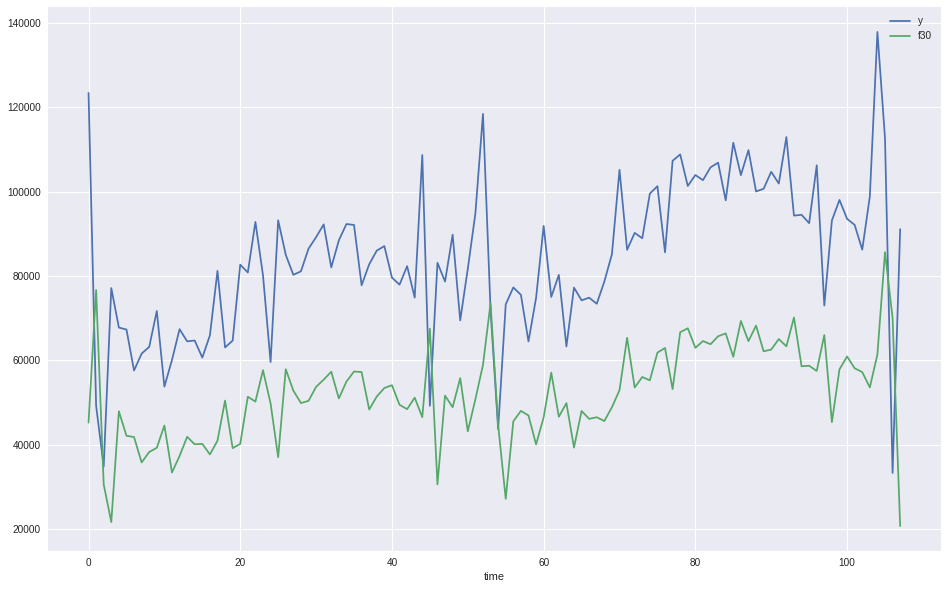

In [41]:
plt.figure(figsize=(16, 10))
plt.plot(time, first_id_data['y'], label='y')
plt.plot(time, first_id_data['f30'], label='f30')
plt.xlabel('time')
plt.grid(True)
plt.legend(loc='best')
plt.show()

Видно, что значения совпадают с точностью до множителя и сдвига на 1 шаг по времени.

Поэтому ответом будут значения f30, умноженные на посчитанный коэффициент между y и f30. Но для последних недель для каждого item_id соответствующего значения f30 нет (из-за сдвига по времени). Поэтому для них будем использовать предсказания полученные ранее.

In [48]:
boost_sample = pd.read_csv('boost_submission_zero.csv')
boost_sample = dict(boost_sample.values)

In [49]:
uids = test['item_id'].unique()
train = train[['Num', 'item_id', 'shift', 'week', 'year', 'f30', 'y']]
test = test[['Num', 'item_id', 'shift', 'week', 'year', 'f30']]

def get_table(item_id):
    id_table_train = train[train['item_id'] == item_id]
    id_table_test = test[test['item_id'] == item_id]

    id_table_train = id_table_train.sort_values(['year', 'week', 'shift'])
    id_table_train = id_table_train[id_table_train['shift'] == 1]
    id_table_test_full = id_table_test.sort_values(['year', 'week', 'shift'])

    id_table_test = id_table_test_full[id_table_test_full['shift'] == 1]

    id_table_test_shift = id_table_test_full[id_table_test_full['shift'] == 2]
    id_table_test['Extra_Num_2'] = id_table_test_shift['Num'].values

    id_table_test_shift = id_table_test_full[id_table_test_full['shift'] == 3]
    id_table_test['Extra_Num_3'] = id_table_test_shift['Num'].values

    full_table = id_table_train.append(id_table_test)
    
    full_table = full_table.drop(['year', 'week', 'shift', 'item_id'], axis=1)
    full_table['f30'] = (list(full_table['f30']) + [None])[1:]
    
    return full_table

In [50]:
with open('submission.csv', 'w') as f: 
    f.write('Num,y\n')
    for item_id in uids:
        table = get_table(item_id=item_id)
        w = []
        for row in table[table['Extra_Num_2'].isnull()].values:
            try:
                w.append(row[-2] / row[-1])
            except TypeError:
                print table
        w0 = np.median(w)
        table = table.drop(['y'], axis=1)[table['Extra_Num_2'].notnull()]
        for row in table.values:
            if not np.isnan(row[-1]):
                y = row[-1] / w0
            else:
                y = np.median([boost_sample[row[0]], boost_sample[row[1]], boost_sample[row[2]]])
            f.write('{},{}\n'.format(int(row[0]), y))
            f.write('{},{}\n'.format(int(row[1]), y))
            f.write('{},{}\n'.format(int(row[2]), y))

/home/boyalex/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/boyalex/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Попробовав 3 варианта xgboost, оказывается, что первый работает получше. SMAPE на public liderboard дали 8.06, 13, 8.37. Таким образом лучшие результаты дали простая модель с хорошими параметрами + работа с данными.

## Доп. вопрос

In [2]:
train['y'].mean()

198575.91203058365

In [5]:
y = pd.read_csv('sample_submission.tsv')
y.head()

,Num,y
0,348622,198575.912031
1,348623,198575.912031
2,348624,198575.912031
3,348625,198575.912031
4,348626,198575.912031


Таким образом sample_submission.tsv - среднее по y на train.